In [1]:
#try:
#  from google.colab import files
#except ImportError:
#  pass
#else:
#  files.download(anim_file)

# 인공지능으로 세상에 없던 새로운 패션 만들기

1. 작업환경 구성하기

In [2]:
import tensorflow as tf
import imageio
import matplotlib.pyplot as plt

print(tf.__version__)
print(imageio.__version__)

2.9.2
2.9.0


2. 데이터셋 구성하기

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170498071/170498071 [==============================] - 6s 0us/step


(50000, 32, 32, 3)

In [4]:
train_x.max()

255

In [5]:
train_x.min()

0

In [6]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [7]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32') #32비트로 축소
train_x.shape

(50000, 32, 32, 3)

In [8]:
train_x[1].shape

(32, 32, 3)

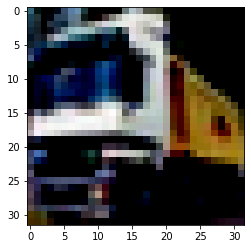

In [9]:
plt.imshow(train_x[1])

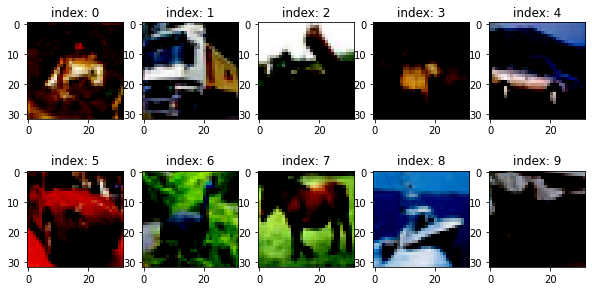

In [10]:
plt.figure(figsize=(10,5))                                    

for i in range(10):
    plt.subplot(2,5,i+1)                                            
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
plt.show()

- 32x32x3 으로 각 index의 사진들이 출력 된 것을 확인

3. 생성자 모델 구현하기

---

- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

In [11]:
# Shuffle 기법중 하나인 BUFFER_SIZE -> 최소 20000부터 시작하는 것이 좋다.
BUFFER_SIZE = 20000
BATCH_SIZE = 256

# 효율적 학습을 위해 배치사이즈를 잘라 한번에 학습할 양을 구분짓는다
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

- DCGAN

In [12]:
from tensorflow.keras import layers

def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First Layer: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) # 가중치 값을 배치 정규화
    model.add(layers.LeakyReLU())

    # Second Layer: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third Layer: Conv2DTranspose layer 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth Layer: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth Layer: Conv2DTranspose layer
    # activation 을 하이퍼블릭 탄젠트 = -1 ~ 1 이내의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh')) 

    return model

![con](https://github.com/fmfmsd/Chamchee/blob/main/Exploration2/Ex11/img/convol.png?raw=true)

- 일반적인 컨볼루션 계산 방법

![tranpos](https://github.com/fmfmsd/Chamchee/blob/main/Exploration2/Ex11/img/convoltranpose.png?raw=true)


- Conv2DTranspose의 계산 방법


> input의 빨간색, 파란색 요소를 3x3 kernel에 곱해서 output의 대응하는 자리에 집어넣는다. 그리고 output에 겹치는 구간(빗금 표시)이 발생하는데, 교집합으로 모든 값을 더해준다.. input의 나머지 원소에 대해서도 동일한 방법으로 계산한다.


In [13]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

In [14]:
noise = tf.random.normal([1, 100]) # [1~100]의 랜덤 노이즈 벡터

In [15]:
generated_image = generator(noise, training=False) # 학습과정이 아니여서 traing - False
generated_image.shape

TensorShape([1, 32, 32, 3])

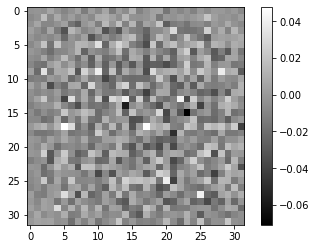

In [16]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray') # matplotlib은 2차원만 출력 가능하기 때문에 1번째, 3번째 축을 0으로 지정
plt.colorbar()
plt.show()

4. 판별자 모델 구현하기

---

- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [17]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First Layer: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3])) # padding='same' -> 필터의 사이즈가 n이면 테두리에 n/2 만큼의 패딩을 준다.
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second Layer: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third Layer: Flatten Layer
    model.add(layers.Flatten())

    # Fourth Layer: Dense Layer
    model.add(layers.Dense(1))

    return model

In [18]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

- (32x32x3) 을 conv2d 층에서 (16x16x64) -> (8x8x128) 의 행렬로 만든 다음에 Flatten Layer를 통해 (8192x1) 형태로 벡터를 Stretch
- 마지막 Dense Layer로 모든 정보를 하나로 뭉쳐준다(8192x1 -> 8193)

In [19]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00656086]], dtype=float32)>

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

 5. 손실함수와 최적화 함수 구현하기

 ---

- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss # 판별자라서 fake랑 real loss를 합치는 걸까?
    return total_loss

In [23]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy 

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-3) 
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3) # 최적화 함수 Adam 1*10^-3 -> learning rate
                                                         # Adam optimizer -> 방향, 스텝사이즈를 적절하게 조절하는 최적화 모듈

6. 훈련과정 상세 기능 구현하기

---

- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [25]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [26]:
@tf.function
def train_step(images): 
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True) 

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  # train step

In [27]:
import time

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [28]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

    plt.savefig('image_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [29]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']= 15, 6

def draw_train_history(history, epoch):
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_losss', 'disc_loss'], loc='upper left')
    
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    plt.savefig('image_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [30]:
import os
from os.path import join
checkpoint_dir = '/content/drive/MyDrive/exploration/Ex11/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                discriminator_optimizer = discriminator_optimizer,
                                generator = generator,
                                discriminator = discriminator)

In [31]:
import time
from IPython import display
from IPython.display import clear_output
from tqdm.auto import trange

In [32]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))
                
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        display.clear_output(wait = True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))
        
        draw_train_history(history,epoch)

7. 학습 과정 진행하기

---

- 위 .5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

In [33]:
save_every = 5
EPOCHS = 50

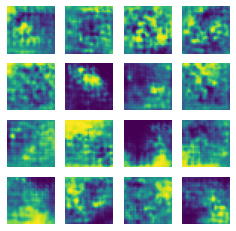

Time for training : 773 sec


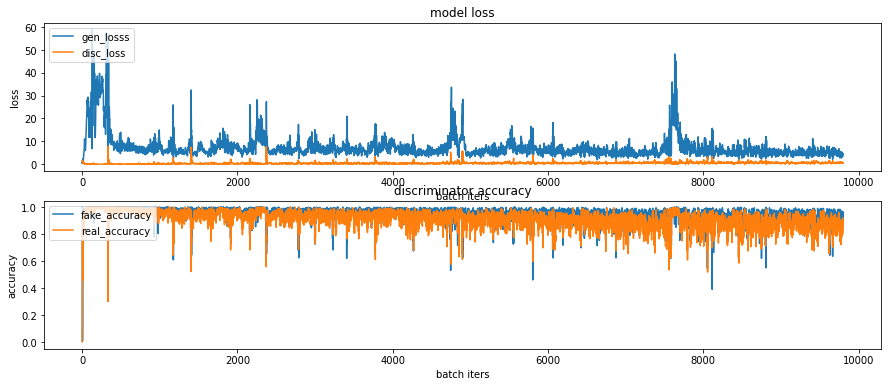

In [34]:
train(train_dataset, EPOCHS, save_every)

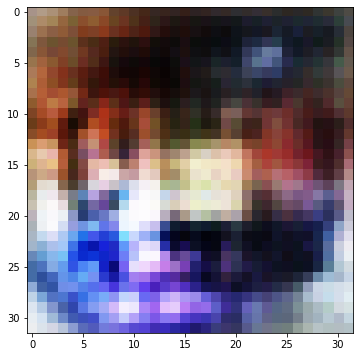

In [40]:
checkpoint_dir = '/content/drive/MyDrive/exploration/Ex11/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int) 
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

8. (optional) GAN 훈련 과정 개선하기

---

- STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
- 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.